In [83]:
import json
import bz2
import sys
import os
import numpy as np
import pandas as pd
import networkx as nx
import networkx.algorithms.community as community
from chart_studio import plotly
from plotly.offline import iplot
import plotly.graph_objs as go
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import plotly.express as px

In [3]:
#possible plot
import plotly.express as px
#df = px.data.gapminder().query("year == 2007")
#fig = px.line_geo(df, locations="country",locationmode='country names', # default 'world').) – One of 'world', 'usa', 'europe', 'asia', 'africa', 'north america', or 'south america'`Default is `'world' unless projection is set to 'albers usa', which forces 'usa'.
#                  color="continent",#,scope = "usa", # "continent" is one of the columns of gapminder
#                  projection="natural earth") #aitoff,orthographic,equirectangular,natural earth

#fig.update_geos(
#    visible=True, resolution=110, scope="world",
#    showcountries=True, countrycolor="Black",
#    showsubunits=True, subunitcolor="Blue"
#)
#fig.show()


In [30]:
#plot for global ...

quotes_world='quotes_mentions_world_compact.json.bz2'
WIKI_DATA_FILTERED='filtered_politician_labeled_us_v3.json.bz2' #catalogue containing all US politician

df_world=pd.read_json(quotes_world, lines=True)
catalogue_df=pd.read_json(WIKI_DATA_FILTERED, lines=True)
catalogue_df.head(3)

,qid,name,gender,nationality,aliases,parties,positions held,religion,us_congress_id,candidacy_election,State
0,Q207,George W. Bush,male,Q30,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[Republican Party],"[[Governor of Texas, [+1995-01-17T00:00:00Z]],...",Q329646,,"[2000 United States presidential election, 200...",Texas
1,Q4496,Mitt Romney,male,Q30,"[Willard Mitt Romney, Pierre Delecto]",[Republican Party],"[[Governor of Massachusetts, [+2003-01-02T00:0...",Q42504,R000615,"[2012 Republican Party presidential primaries,...",Massachusetts
2,Q11124,Stephen Breyer,male,Q30,[Stephen Gerald Breyer],[Democratic Party],[[Associate Justice of the Supreme Court of th...,Q9268,,[],None


In [31]:
#to have republican and demo only
catalogue_df=catalogue_df.loc[catalogue_df.parties.apply(len) !=0]
catalogue_df.parties=[x[0] for x in catalogue_df.parties]
catalogue_df.loc[catalogue_df.parties == 'Minnesota Democratic–Farmer–Labor Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Iowa Democratic Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'California Democratic Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Maine Democratic Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'North Dakota Democratic-Nonpartisan League Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Democratic Party of Oregon','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Utah Democratic Party','parties']='Democratic Party'

catalogue_df.loc[catalogue_df.parties == 'Republican Party of Minnesota','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Republican Party of Iowa','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'California Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Maine Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Utah Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Oregon Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'North Dakota Republican Party','parties']='Republican Party'
catalogue_df=catalogue_df.loc[(catalogue_df.parties =='Democratic Party') | (catalogue_df.parties =='Republican Party')]#keep only republican and democrate parties and affiliates
catalogue_df.head(5)

,qid,name,gender,nationality,aliases,parties,positions held,religion,us_congress_id,candidacy_election,State
0,Q207,George W. Bush,male,Q30,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",Republican Party,"[[Governor of Texas, [+1995-01-17T00:00:00Z]],...",Q329646,,"[2000 United States presidential election, 200...",Texas
1,Q4496,Mitt Romney,male,Q30,"[Willard Mitt Romney, Pierre Delecto]",Republican Party,"[[Governor of Massachusetts, [+2003-01-02T00:0...",Q42504,R000615,"[2012 Republican Party presidential primaries,...",Massachusetts
2,Q11124,Stephen Breyer,male,Q30,[Stephen Gerald Breyer],Democratic Party,[[Associate Justice of the Supreme Court of th...,Q9268,,[],None
3,Q11674,David Paterson,male,Q30,[David Alexander Paterson],Democratic Party,"[[Governor of New York, [+2008-03-17T00:00:00Z...",,,[],New York
4,Q22201,Jim DeMint,male,Q30,"[James Warren ""Jim"" DeMint, James Warren DeMint]",Republican Party,"[[United States representative, []], [United S...",Q178169,D000595,[],None


In [32]:
df_world.head(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,phase,mentions,mentions_qids,urls,country
0,2015-07-24-075914,Prime Minister Modi recognizes the vital role ...,Michael R. Bloomberg,Q607,2015-07-24 15:56:32,1,E,[Narendra Modi],[Q1058],[businessfacilities.com],[India]
1,2015-09-24-093742,The growing reach of China's army of cyberwarr...,President Barack Obama,Q76,2015-09-24 13:50:51,2,E,[Xi Jinping],[Q15031],"[www.defenseone.com, defenseone.com]",[People's Republic of China]
2,2015-12-21-013885,deal with [ Putin ],Marco Rubio,Q324546,2015-12-21 00:00:00,1,E,[Vladimir Putin],[Q7747],[latinpost.com],[Russia]
3,2015-01-09-015364,free for eve... Girls basketball notebook: Rul...,President Barack Obama,Q76,2015-01-09 03:37:35,1,E,[Maithripala Sirisena],[Q6737124],[billingsgazette.com],[Sri Lanka]
4,2015-02-11-030684,I hope the president does see the value of let...,Madeleine Albright,Q174438,2015-02-11 18:35:22,1,E,"[Angela Merkel, Vladimir Putin]","[Q567, Q7747]",[breitbart.com],"[Germany, Russia]"


In [76]:
len(df_world)

26175

In [70]:
part=pd.DataFrame()#obtain the parties from catalogue
for i,qid in enumerate(df_world.qids):
    party=[catalogue_df[catalogue_df['qid'] == qid].parties.tolist()]
    part=part.append(party,ignore_index=True)
    if i%5000==0 : print(i)
part.rename(columns={0:'party'},inplace=True)
part.head()
#print(part)

0
5000
10000
15000
20000
25000


,party
0,Democratic Party
1,Democratic Party
2,Republican Party
3,Democratic Party
4,Democratic Party


In [72]:
df_world['party']=part
df_world.head(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,phase,mentions,mentions_qids,urls,country,party
0,2015-07-24-075914,Prime Minister Modi recognizes the vital role ...,Michael R. Bloomberg,Q607,2015-07-24 15:56:32,1,E,[Narendra Modi],[Q1058],[businessfacilities.com],[India],Democratic Party
1,2015-09-24-093742,The growing reach of China's army of cyberwarr...,President Barack Obama,Q76,2015-09-24 13:50:51,2,E,[Xi Jinping],[Q15031],"[www.defenseone.com, defenseone.com]",[People's Republic of China],Democratic Party
2,2015-12-21-013885,deal with [ Putin ],Marco Rubio,Q324546,2015-12-21 00:00:00,1,E,[Vladimir Putin],[Q7747],[latinpost.com],[Russia],Republican Party
3,2015-01-09-015364,free for eve... Girls basketball notebook: Rul...,President Barack Obama,Q76,2015-01-09 03:37:35,1,E,[Maithripala Sirisena],[Q6737124],[billingsgazette.com],[Sri Lanka],Democratic Party
4,2015-02-11-030684,I hope the president does see the value of let...,Madeleine Albright,Q174438,2015-02-11 18:35:22,1,E,"[Angela Merkel, Vladimir Putin]","[Q567, Q7747]",[breitbart.com],"[Germany, Russia]",Democratic Party


In [73]:
df1=df_world[['quoteID','qids','speaker','mentions_qids','mentions','country','party']] #extract info of quotations taking only USA politicians mentions of USA politician in the US catalogue
mentions_w_df=pd.DataFrame()
for i,row in df1.iterrows():
    for j,mention_qid in enumerate(row.mentions_qids):
        mention=pd.Series([row.quoteID,row.qids,row.speaker,mention_qid,row.mentions[j],row.country[j],row.party])
        mentions_w_df=mentions_w_df.append(mention,ignore_index=True)
        if i %10000==0: print(i)
mentions_w_df.rename(columns={0:'quoteID',1:'qid',2:'mention_qid',3:'mentioned',4:'speaker',5:'country',6:'party'},inplace=True)
print(mentions_w_df.head())
print(f'men_df shape {mentions_w_df.shape}')

0
10000
20000
             quoteID      qid             mention_qid mentioned  \
0  2015-07-24-075914     Q607    Michael R. Bloomberg     Q1058   
1  2015-09-24-093742      Q76  President Barack Obama    Q15031   
2  2015-12-21-013885  Q324546             Marco Rubio     Q7747   
3  2015-01-09-015364      Q76  President Barack Obama  Q6737124   
4  2015-02-11-030684  Q174438      Madeleine Albright      Q567   

                speaker                     country             party  
0         Narendra Modi                       India  Democratic Party  
1            Xi Jinping  People's Republic of China  Democratic Party  
2        Vladimir Putin                      Russia  Republican Party  
3  Maithripala Sirisena                   Sri Lanka  Democratic Party  
4         Angela Merkel                     Germany  Democratic Party  
men_df shape (26702, 7)


In [74]:
mentions_w_df.head()

,quoteID,qid,mention_qid,mentioned,speaker,country,party
0,2015-07-24-075914,Q607,Michael R. Bloomberg,Q1058,Narendra Modi,India,Democratic Party
1,2015-09-24-093742,Q76,President Barack Obama,Q15031,Xi Jinping,People's Republic of China,Democratic Party
2,2015-12-21-013885,Q324546,Marco Rubio,Q7747,Vladimir Putin,Russia,Republican Party
3,2015-01-09-015364,Q76,President Barack Obama,Q6737124,Maithripala Sirisena,Sri Lanka,Democratic Party
4,2015-02-11-030684,Q174438,Madeleine Albright,Q567,Angela Merkel,Germany,Democratic Party


In [79]:
#change Danish Realm = Danemark (otherwhise can not have localisation)
mentions_w_df.loc[mentions_w_df.country=='Danish Realm','country']='Danemark'
#add_sentiment random for later:
mentions_w_df['sentiment']= np.random.rand(mentions_w_df.shape[0])

In [80]:
mentions_w_df['year'] = mentions_w_df['quoteID'].apply(lambda x: x[:4])
mentions_w_df['month'] = mentions_w_df['quoteID'].apply(lambda x: x[:7])#month maybe too much !!!! NEED TO BE ORDERED
mentions_w_df.head(10)

,quoteID,qid,mention_qid,mentioned,speaker,country,party,sentiment,year,month
0,2015-07-24-075914,Q607,Michael R. Bloomberg,Q1058,Narendra Modi,India,Democratic Party,0.486043,2015,2015-07
1,2015-09-24-093742,Q76,President Barack Obama,Q15031,Xi Jinping,People's Republic of China,Democratic Party,0.597371,2015,2015-09
2,2015-12-21-013885,Q324546,Marco Rubio,Q7747,Vladimir Putin,Russia,Republican Party,0.726264,2015,2015-12
3,2015-01-09-015364,Q76,President Barack Obama,Q6737124,Maithripala Sirisena,Sri Lanka,Democratic Party,0.729926,2015,2015-01
4,2015-02-11-030684,Q174438,Madeleine Albright,Q567,Angela Merkel,Germany,Democratic Party,0.401998,2015,2015-02
5,2015-02-11-030684,Q174438,Madeleine Albright,Q7747,Vladimir Putin,Russia,Democratic Party,0.960724,2015,2015-02
6,2015-03-05-066673,Q22316,John Kerry,Q7747,Vladimir Putin,Russia,Democratic Party,0.953360,2015,2015-03
7,2015-01-26-053529,Q76,President Barack Obama,Q1058,Narendra Modi,India,Democratic Party,0.866862,2015,2015-01
8,2015-02-22-003462,Q10853588,Kamala Harris,Q7747,Vladimir Putin,Russia,Democratic Party,0.836532,2015,2015-02
9,2015-02-12-060236,Q76,President Barack Obama,Q7747,Vladimir Putin,Russia,Democratic Party,0.490472,2015,2015-02


In [697]:
year_m=mentions_w_df.groupby(['year'])
x1=group_years.get_group('2015')
x2=x1.groupby(['country'])
#x2.sentiment.mean()# or quantile...?
x3=(x2.count().qid-x2.count().qid.min())/(x2.count().qid.max()-x2.count().qid.min())
x2.sentiment

In [94]:
#add the positions of countries
geolocator = Nominatim(user_agent="my_user_agent")
geoloc=pd.DataFrame()
countr=mentions_w_df.groupby(['country'])
for i,count in enumerate(countr.indices):
    #colour.append(colorsys.hsv_to_rgb(sent[i],freq[i],1))
    geo=geolocator.geocode(count)[1]
    geoloc=geoloc.append({'lat':geo[0],'lon':geo[1]},ignore_index=True)
    #lat.append(geoloc[0])
    #lon.append(geoloc[1])
    if i%40==0 : print(count)
geoloc.index=countr.indices
geoloc.head()

Albania
Italy
United Kingdom


,lat,lon
Albania,41.000028,19.999962
Argentina,-34.996496,-64.967282
Armenia,40.769627,44.673665
Australia,-24.776109,134.755000
Azerbaijan,40.393629,47.787251


In [97]:
years= ['2015','2016','2017','2018','2019','2020']

Coun_year=pd.DataFrame()

group_years=mentions_w_df.groupby(['year'])
for y in years:
    y1=group_years.get_group(y)
    y2=y1.groupby(['country'])
    #freq=y2.count().qid/len(y1)#freq of number of countries mentioned that year 
    freq= (y2.count().qid-y2.count().qid.min())/(y2.count().qid.max()-y2.count().qid.min())#normalized by min/max and round
    lat=[]
    lon=[]
    sent=(y2.sentiment.mean()-y2.sentiment.mean().min())/(y2.sentiment.mean().max()-y2.sentiment.mean().min())#normalized by min/max or quantile .. ?
    #colour=[]
    for i,count in enumerate(y2.indices):
        #colour.append(colorsys.hsv_to_rgb(sent[i],freq[i],1))
        #geoloc=geolocator.geocode(count)[1]
        lat.append(geoloc.loc[count,'lat'])
        lon.append(geoloc.loc[count,'lon'])
        if i%40==0 : print(count)
    countries=pd.DataFrame({'country':freq.index,'freq':freq.values,'year':y,'lat':lat,'lon':lon, 'sentiment':sent})#,'color':colour
    Coun_year=Coun_year.append(countries,ignore_index=True)
Coun_year.head()

Argentina
Albania
Azerbaijan
Yemen
Albania
Rwanda
Argentina
Pakistan
Argentina


,country,freq,year,lat,lon,sentiment
0,Argentina,0.000000,2015,-34.996496,-64.967282,0.402987
1,Bangladesh,0.000663,2015,23.503102,90.003865,0.352482
2,Canada,0.009940,2015,61.066692,-107.991707,0.578538
3,Dominican Republic,0.000663,2015,19.281318,-70.035907,0.138126
4,Ecuador,0.009940,2015,-1.339767,-79.366697,0.511039


In [99]:
#do only for republi and democra
mention_repub= mentions_w_df[mentions_w_df['party']=='Republican Party']
mention_democ= mentions_w_df[mentions_w_df['party']=='Democratic Party']
mention_democ.head(3)

,quoteID,qid,mention_qid,mentioned,speaker,country,party,sentiment,year,month
0,2015-07-24-075914,Q607,Michael R. Bloomberg,Q1058,Narendra Modi,India,Democratic Party,0.486043,2015,2015-07
1,2015-09-24-093742,Q76,President Barack Obama,Q15031,Xi Jinping,People's Republic of China,Democratic Party,0.597371,2015,2015-09
3,2015-01-09-015364,Q76,President Barack Obama,Q6737124,Maithripala Sirisena,Sri Lanka,Democratic Party,0.729926,2015,2015-01


In [103]:
len(mention_repub)

17754

In [104]:
len(mention_democ)

7207

In [111]:
#Now for republic
Coun_year_repub=pd.DataFrame()

g_y_repub=mention_repub.groupby(['year'])
for y in years:
    y1=g_y_repub.get_group(y)
    y2=y1.groupby(['country'])
    #freq=y2.count().qid/len(y1)#freq of number of countries mentioned that year 
    freq= (y2.count().qid-y2.count().qid.min())/(y2.count().qid.max()-y2.count().qid.min())#normalized by min/max and round
    lat=[]
    lon=[]
    sent=(y2.sentiment.mean()-y2.sentiment.mean().min())/(y2.sentiment.mean().max()-y2.sentiment.mean().min())#normalized by min/max or quantile .. ?
    #colour=[]
    for i,count in enumerate(y2.indices):
        #colour.append(colorsys.hsv_to_rgb(sent[i],freq[i],1))
        #geoloc=geolocator.geocode(count)[1]
        lat.append(geoloc.loc[count,'lat'])
        lon.append(geoloc.loc[count,'lon'])
        if i%40==0 : print(count)
    countries=pd.DataFrame({'country':freq.index,'freq':freq.values,'year':y,'lat':lat,'lon':lon, 'sentiment':sent})#,'color':colour
    Coun_year_repub=Coun_year_repub.append(countries,ignore_index=True)
Coun_year_repub.head()

Canada
Argentina
Azerbaijan
Albania
Singapore
Argentina
South Africa
Argentina


,country,freq,year,lat,lon,sentiment
0,Canada,0.014840,2015,61.066692,-107.991707,0.599110
1,Ecuador,0.007991,2015,-1.339767,-79.366697,0.556473
2,Egypt,0.011416,2015,26.254049,29.267547,0.491357
3,Germany,0.034247,2015,51.083420,10.423447,0.760220
4,Guyana,0.000000,2015,4.841710,-58.641689,1.000000


In [112]:
#Now for democa
Coun_year_democ=pd.DataFrame()

g_y_democ=mention_democ.groupby(['year'])
for y in years:
    y1=g_y_democ.get_group(y)
    y2=y1.groupby(['country'])
    #freq=y2.count().qid/len(y1)#freq of number of countries mentioned that year 
    freq= (y2.count().qid-y2.count().qid.min())/(y2.count().qid.max()-y2.count().qid.min())#normalized by min/max and round
    lat=[]
    lon=[]
    sent=(y2.sentiment.mean()-y2.sentiment.mean().min())/(y2.sentiment.mean().max()-y2.sentiment.mean().min())#normalized by min/max or quantile .. ?
    #colour=[]
    for i,count in enumerate(y2.indices):
        #colour.append(colorsys.hsv_to_rgb(sent[i],freq[i],1))
        #geoloc=geolocator.geocode(count)[1]
        lat.append(geoloc.loc[count,'lat'])
        lon.append(geoloc.loc[count,'lon'])
        if i%40==0 : print(count)
    countries=pd.DataFrame({'country':freq.index,'freq':freq.values,'year':y,'lat':lat,'lon':lon, 'sentiment':sent})#,'color':colour
    Coun_year_democ=Coun_year_democ.append(countries,ignore_index=True)
Coun_year_democ.head()

Argentina
Albania
Cambodia
Australia
Australia
Australia


,country,freq,year,lat,lon,sentiment
0,Argentina,0.000000,2015,-34.996496,-64.967282,0.423332
1,Bangladesh,0.001704,2015,23.503102,90.003865,0.374549
2,Canada,0.000000,2015,61.066692,-107.991707,0.618554
3,Dominican Republic,0.001704,2015,19.281318,-70.035907,0.167497
4,Ecuador,0.003407,2015,-1.339767,-79.366697,0.448236


In [113]:
Coun_year_democ.head(10)

,country,freq,year,lat,lon,sentiment
0,Argentina,0.000000,2015,-34.996496,-64.967282,0.423332
1,Bangladesh,0.001704,2015,23.503102,90.003865,0.374549
2,Canada,0.000000,2015,61.066692,-107.991707,0.618554
3,Dominican Republic,0.001704,2015,19.281318,-70.035907,0.167497
4,Ecuador,0.003407,2015,-1.339767,-79.366697,0.448236
5,Egypt,0.018739,2015,26.254049,29.267547,0.579802
6,Finland,0.000000,2015,63.246778,25.920916,0.332300
7,Germany,0.063032,2015,51.083420,10.423447,0.487334
8,Guyana,0.001704,2015,4.841710,-58.641689,0.779479
9,India,0.424191,2015,22.351115,78.667743,0.495676


In [114]:
Coun_year_repub.head(10)

,country,freq,year,lat,lon,sentiment
0,Canada,0.014840,2015,61.066692,-107.991707,0.599110
1,Ecuador,0.007991,2015,-1.339767,-79.366697,0.556473
2,Egypt,0.011416,2015,26.254049,29.267547,0.491357
3,Germany,0.034247,2015,51.083420,10.423447,0.760220
4,Guyana,0.000000,2015,4.841710,-58.641689,1.000000
5,Hungary,0.000000,2015,47.181759,19.506094,0.000000
6,India,0.029680,2015,22.351115,78.667743,0.528441
7,Iran,0.018265,2015,32.647531,54.564352,0.595284
8,Israel,0.000000,2015,31.531311,34.866765,0.583989
9,Italy,0.000000,2015,42.638426,12.674297,0.044428


In [115]:
#The origin of the lines:
locO = geolocator.geocode('USA')

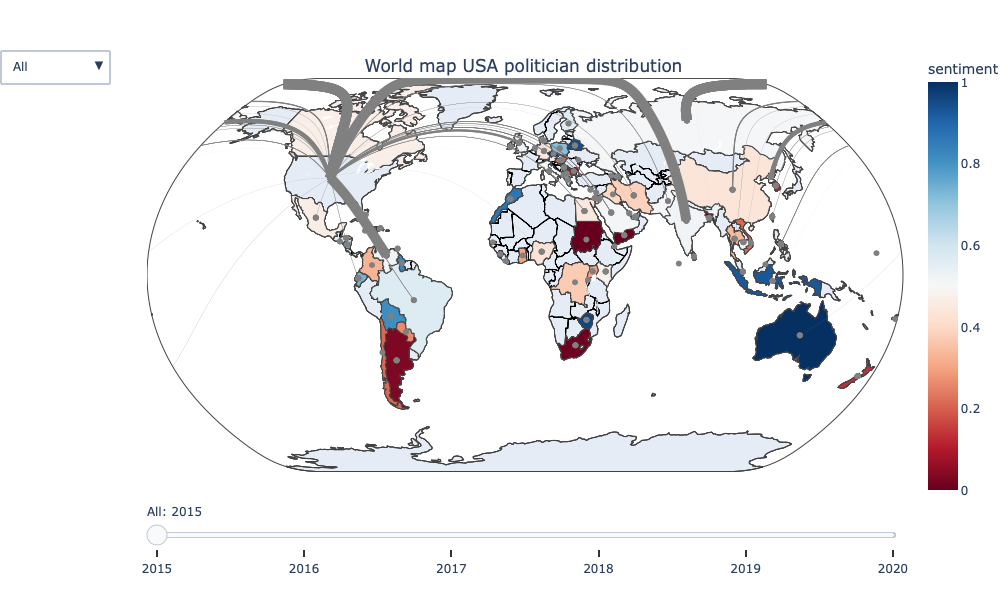

In [990]:
#add by year

years= ['2015','2016','2017','2018','2019','2020']

#we group the data by the years
by_year=Coun_year.groupby('year')
by_year_democ=Coun_year_democ.groupby('year')
by_year_repub=Coun_year_repub.groupby('year')
parti=[]
#add first graph
Figures=[] #all the traces and figures 
years_a=[] #the year of each figure to classify 

for i,year in enumerate(years) : 
    #extract the data by year
    y=by_year.get_group(year)
    yd=by_year_democ.get_group(year)
    yr=by_year_repub.get_group(year)
    #add the choropleth for each year from all the USA quotes
    Figures.append(go.Choropleth(coloraxis='coloraxis',
                                      z=y['sentiment'],
                                      locations=y['country'],
                                      locationmode='country names',
                                      hoverinfo='location + z',
                                      visible=True
                                ))
    #add labels for year and parties
    parti.append('All')
    years_a.append(year)
    #add the lines for each year (all quotes)
    for j,country in y.iterrows():
        Figures.append(go.Scattergeo(
                         lat=[locO[1][0],country.lat], 
                         lon=[locO[1][1],country.lon],
                         mode='lines+markers',
                         name='All',
                         hovertext=country.country+' freq ='+str(country.freq),
                         line=dict(width=country.freq*10, color='grey'),
                         visible=True,
                         showlegend=False
        ))
        parti.append('All') #add labels for year and parties
        years_a.append(year)
    #now for democratic party
    Figures.append(go.Choropleth(coloraxis='coloraxis',
                                     z=yd['sentiment'],
                                     locations=yd['country'],
                                     locationmode='country names',
                                     hoverinfo='location + z',
                                     visible=False
                                ))
    #add label
    parti.append('Democ')
    years_a.append(year)
    for j,country in yd.iterrows():
        Figures.append(go.Scattergeo(
                         lat=[locO[1][0],country.lat], 
                         lon=[locO[1][1],country.lon],
                         mode='lines+markers',
                         name='All',
                         hovertext=country.country+' freq ='+str(country.freq),
                         line=dict(width=country.freq*10, color='blue'),
                         visible=False,
                         showlegend=False
        ))
        parti.append('Democ')
        years_a.append(year)
    #now for republican 
    Figures.append(go.Choropleth(coloraxis='coloraxis',
                                      z=yr['sentiment'],
                                      locations=yr['country'],
                                      locationmode='country names',
                                      hoverinfo='location + z',
                                     visible=False
                                ))
    parti.append('Repub')
    years_a.append(year)
    for j,country in yr.iterrows():
        Figures.append(go.Scattergeo(
                         lat=[locO[1][0],country.lat], 
                         lon=[locO[1][1],country.lon],
                         mode='lines+markers',
                         name='All',
                         hovertext=country.country+' freq ='+str(country.freq),
                         line=dict(width=country.freq*10, color='red'),
                         visible=False,
                         showlegend=False
        ))
        parti.append('Repub')
        years_a.append(year)
#we create the layout of the graph
layout = go.Layout(margin={"r":0,"t":50,"l":0,"b":100}, #marges
                   mapbox_style="carto-positron",
                   title="World map USA politician distribution",title_x=0.52,title_y=0.9, #title
                   showlegend=False,hovermode='closest',height=600
            )
fig=go.Figure(data=Figures,layout=layout)#creation of the graph
fig.update_geos(
    visible=True, resolution=110,projection=dict(type="natural earth"),
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Blue"
)
#add the colorscale
fig.update_coloraxes(
    colorbar=dict(title='sentiment'),
    colorscale='RdBu'
)
#steps for the different sliders
steps=[]
steps2=[]
steps3=[]
for year in years:
    step=dict(
        method='update',
        label=year,
        args=[{"visible": [(a==year)&(parti[i]=='All') for i,a in enumerate(years_a)]},
                  {"title": "World map USA politician distribution in : " + year}] 
        )
    steps.append(step)
    step2=dict(
        method='update',
        label=year,
        args=[{"visible": [(a==year)&(parti[i]=='Democ') for i,a in enumerate(years_a)]},
                  {"title": "World map Democratic distribution : " + year}] 
        )
    steps2.append(step2)
    step3=dict(
        method='update',
        label=year,
        args=[{"visible": [(a==year)&(parti[i]=='Repub') for i,a in enumerate(years_a)]},
                  {"title": "World map Republican distribution : " + year}] 
        )
    steps3.append(step3)
#creation of sliders
sliders = [dict(
        active=0,
        currentvalue={"prefix": "All: "},
        pad={"t": 0},
        steps=steps,
        visible=True
        
    ),dict(
        active=0,
        currentvalue={"prefix": "Democratic: "},
        pad={"t": 0},
        steps=steps2,
        visible=False
        
    ),dict(
        active=0,
        currentvalue={"prefix": "Republican: "},
        pad={"t": 0},
        steps=steps3,
        visible=False
        
    )
    ]
#addition of sliders to graph
fig.update_layout(
        sliders=sliders
    )
#creation of dropdown buttons
updt=[]
updt.append(dict(buttons=list([dict(args=[{'visible':[(a=='2015')&(parti[i]=='All') for i,a in enumerate(years_a)]},
                                          {"title":"World map USA politician distribution in : 2015",
                                                'sliders[0].visible': True,'sliders[0].active':0, #active the current slide
                                                 'sliders[1].visible': False,'sliders[2].visible':False #hide the others
                                            }],   
                                        label='All',
                                        method="update"
                                        
                                         ),
                               
                               #dict(args=[{"visible": [i=='Democ' for i in parti]},
                               dict(args=[{'visible':[(a=='2015')&(parti[i]=='Democ') for i,a in enumerate(years_a)]},
                                          {"title":"World map Democratic distribution in : 2015",'sliders[1].visible': True,'sliders[1].active':0,#active current slide
                                           'sliders[0].visible': False,'sliders[2].visible':False #hide the others
                                          } ], label='Democratic',
                                    method="update"
                                   ),
                               dict(args=[{'visible':[(a=='2015')&(parti[i]=='Repub') for i,a in enumerate(years_a)]},
                                          {"title":"World map Republican distribution in : 2015",'sliders[2].visible': True,'sliders[2].active':0,
                                          'sliders[0].visible': False,'sliders[1].visible':False #hide the others
                                          }], label='Republican',
                                   method="update"
                                   )
                                  ]))) 


fig.layout.updatemenus=updt
fig.show()
#dir(fig.layout)
#dir(fig.layout.sliders[0])                             
#print(fig.data)
#print(fig.layout)


In [918]:
#import plotly.offline as off
#old version
#may add one?
years= ['2015','2016','2017','2018','2019','2020']


#lat2 = [locO[1][0], -34.9964963]
#lon2 = [locO[1][1], -64.9672817]

#figures


fig = px.choropleth(Coun_year,locations="country",locationmode='country names',animation_frame="year",#animation_group="All",
                    color="sentiment", # lifeExp is a column of gapminder
                    hover_name="country",
                    #name='All',
                    #hover_data="freq",# column to add to hover information
                    #color_discrete_sequence=Coun_year['color']
                    color_continuous_scale=px.colors.sequential.RdBu, projection="natural earth"#,
                    #mapbox_style="open-street-map")
                    )#,px.line_geo(lat=lat2,lon=lon2,animation_frame=['2015','2015'])]


#add by year
by_year=Coun_year.groupby('year')
#first 2015
#by_first=Coun_year[Coun_year['year']=='2015']
#fr=[fig.frames[0].data[0]]
#fr_name=[fig.frames[0].name]
#all=by_year
#*(len(Coun_year+1))#np.full((len(Coun_year +1),1), True)#((len(Coun_year +1)), dtype=bool)#np.array(True,len(Coun_year+1))

by_year_democ=Coun_year_democ.groupby('year')
by_year_repub=Coun_year_repub.groupby('year')
parti=['All']

#all_a=[True]*(len(Coun_year)+1)
#not_b=[False]*(len(Coun_year_democ)+1)
#not_c=[False]*(len(Coun_year_repub)+1)
#a_n_b= all_a+not_b+not_c
#b_n_a= np.invert(a_n_b)
for i,year in enumerate(years) : 
    #fr=[fig.frames[i].data[0]]#select the current frames and add next data on them
    y=by_year.get_group(year)
    #all_a=all_a(True)
    for j,country in y.iterrows():
        fig.add_traces(go.Scattergeo(
        #fr.append(dict(type='scattergeo', #version1
                         lat=[locO[1][0],country.lat], 
                         lon=[locO[1][1],country.lon],
                         #geo='geo',
                         mode='lines+markers',
                         name='All',
                         hovertext=country.country+' freq ='+str(country.freq),
                         line=dict(width=country.freq*10, color='black'),
                         #text=country.country,
                         #textposition='middle center',
                         #opacity=country.freq,
                         showlegend=False#,
                         #hoverinfo='text'
        ))
        parti.append('All')
        #fr_name.append("2015")
        #dat.append(dict(type='scattergeo',
        #if year=='2015': #version1
        #    fig.add_traces(go.Scattergeo(
        #                     lat=[locO[1][0],country.lat], 
        #                     lon=[locO[1][1],country.lon],
        #                     geo='geo',
        #                     mode='lines+markers',
        #                     #marker.symbol="triangle-up",
        #                     name='All',
        #                     #text=country,
        #                     hovertext=country.country+' freq ='+str(country.freq),
        #                     line=dict(width=country.freq*10, color='black'),
        #                     showlegend=False#,
                             #hoverinfo='text'
        #    ))
    #fig.frames[i].data=fr
    #for i,year in enumerate(years) : #consider sames years
    #fr=fig.frames[i].data#select the current frames and add next data on them
#add chloro for democ
fig.add_traces(go.Choropleth(coloraxis='coloraxis',#colorscale='RdBu',
                              z=Coun_year_democ['sentiment'],
                              locations=Coun_year_democ['country'],
                              locationmode='country names',
                              hoverinfo='location + z',
                             visible=False
                             #geo='geo2'


))
parti.append('Democ')
y_democ=by_year_democ.get_group(year)
for i,year in enumerate(years) :    #all_a=all_a(True)
    for jd,countryd in y_democ.iterrows():
        fig.add_traces(go.Scattergeo(
        #fr.append(dict(type='scattergeo',#version1
                         lat=[locO[1][0],countryd.lat], 
                         lon=[locO[1][1],countryd.lon],
                         #geo='geo2',
                         mode='lines+markers',
                         #legendgroup="Democrat",
                         name="Democrat",
                         hovertext=countryd.country+' freq ='+str(countryd.freq),
                         line=dict(width=countryd.freq*10, color='blue'),
                         #text=country.country,
                         #textposition='middle center',
                         #opacity=country.freq,
                         showlegend=False,
                         visible=False
                         #hoverinfo='text'
        ))
        parti.append('Democ')
        #fr_name.append("2015")
        #dat.append(dict(type='scattergeo',
        #if year=='2015':#version1
        #    fig.add_traces(go.Scattergeo(
        #                     lat=[locO[1][0],countryd.lat], 
        #                     lon=[locO[1][1],countryd.lon],
        #                     geo='geo',
        #                     mode='lines+markers',
        #                     #marker.symbol="triangle-up",
        #                     legendgroup="Democrat",
                             #name="Democrat",
                             #text=country,
        #                     hovertext=countryd.country+' freq ='+str(countryd.freq),
        #                     line=dict(width=countryd.freq*10, color='blue'),
        #                     showlegend=False#,
                             #hoverinfo='text'
        #    ))
    #fig.frames[i].data=fr #version1
#add chloro for REPUBLICAN
fig.add_traces(go.Choropleth(coloraxis='coloraxis',#colorscale='RdBu',
                              z=Coun_year_repub['sentiment'],
                              locations=Coun_year_repub['country'],
                              locationmode='country names',
                              hoverinfo='location + z',
                             visible=False
                             #geo='geo2'


))
parti.append('Repub')
y_repub=by_year_repub.get_group(year)
for i,year in enumerate(years) :    #all_a=all_a(True)
    for jd,countryd in y_repub.iterrows():
        fig.add_traces(go.Scattergeo(
        #fr.append(dict(type='scattergeo',#version1
                         lat=[locO[1][0],countryd.lat], 
                         lon=[locO[1][1],countryd.lon],
                         #geo='geo2',
                         mode='lines+markers',
                         #legendgroup="Democrat",
                         name="Republican",
                         hovertext=countryd.country+' freq ='+str(countryd.freq),
                         line=dict(width=countryd.freq*10, color='green'),
                         #text=country.country,
                         #textposition='middle center',
                         #opacity=country.freq,
                         showlegend=False,
                         visible=False
                         #hoverinfo='text'
        ))
        parti.append('Repub')
    
#fig.frames[0].name=fr_name
#by_second=Coun_year[Coun_year['year']=='2016']

#nd=[fig.frames[1].data[0]]
#dat=[fig.data[0]]

#for i,country in by_second.iterrows():
#    nd.append(dict(type='scattergeo',
#                     #coloraxis='coloraxis',
#                     lat=[locO[1][0],country.lat], 
#                     lon=[locO[1][1],country.lon],
#                     geo='geo',
#                     mode='lines',
 #                    name='',
                     #text=country,
#                     line=dict(width=country.freq*10, color='black'),
#                     showlegend=False#,
                     #hoverinfo='text'
#    ))
    
#updatemenus[0]['buttons'].append(dict(args=[{'visible': vis_list[s]},
#                                               {'mapbox.layers': lay_list[s]}],
#                                          label=party_list[s],
#                                          method='update'))

#fig.layout.updatemenus[0].buttons[1].args[1]['visible']=True
#.append(dict(args=[{'visible': True}],#vis_list[s]},
#                                               #{'mapbox.layers': lay_list[s]}],
#                                          label='new',
#                                          method='update'))
fig.update_geos(
    visible=True, resolution=110,# scope="world",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Blue"
)
fig.update_layout(height=600, margin={"r":0,"t":50,"l":0,"b":0},mapbox_style="carto-positron",title="World map USA politician distribution",title_x=0.45,
                 showlegend=False,hovermode='closest')
#off.iplot({'data': dat,'layout': b}, validate=False)

party_list=['All','Democratic','Republican']
#
#fig.layout.updatemenus.append(dict(buttons(dict(args=[None],#{'visible': vis_list[s]},
                                               #{'mapbox.layers': lay_list[s]}],
#                                          label=party_list,
#                                          method='update'))))
updt=[fig.layout.updatemenus[0]] #version1
#updt.append(go.layout.updatemenu.Button(dict(args=[{'visible': True}],
                                               #{'mapbox.layers': lay_list[s]}],
#                                                    label='All'#,
                                                    #method='update'
#                                                         )))
#updt=[]
#updt.append(dict(buttons=list([dict(args=[{'visible': a_n_b},{"title":"World map USA politician distribution "}],
updt.append(dict(buttons=list([dict(args=[{'visible': [i=='All' for i in parti]},{"title":"World map USA politician distribution "}],                                            #{'mapbox.layers': lay_list[s]}],
                                        label='All',
                                        method="update"
                                        
                                         ),
                               dict(args=[{"visible": [i=='Democ' for i in parti]},{"title":"World map USA Democratic distribution "}], label='Democratic',
                                    method="update"
                                   ),
                               dict(args=[{'visible': [i=='Repub' for i in parti]}], label='Republican')
                              ]),showactive=True)) #,dict(showactive=True)))

fig.layout.updatemenus=updt
#fig.layout.updatemenus[0].buttons[0].args[1]['transition']['easing']='quadratic_in_out'
#fig.show()
#print(fig.layout)
#print(fig.frames[0])
print(fig.layout)
#print(fig.data[0].coloraxis)
#print(fig.frames)

Layout({
    'coloraxis': {'colorbar': {'title': {'text': 'sentiment'}},
                  'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                                 [0.2, 'rgb(214,96,77)'], [0.3,
                                 'rgb(244,165,130)'], [0.4, 'rgb(253,219,199)'],
                                 [0.5, 'rgb(247,247,247)'], [0.6,
                                 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                                 [0.8, 'rgb(67,147,195)'], [0.9,
                                 'rgb(33,102,172)'], [1.0, 'rgb(5,48,97)']]},
    'geo': {'center': {},
            'countrycolor': 'Black',
            'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
            'projection': {'type': 'natural earth'},
            'resolution': 110,
            'showcountries': True,
            'showsubunits': True,
            'subunitcolor': 'Blue',
            'visible': True},
    'height': 600,
    'hovermode': 'closest',
    'legend': {'tracegr

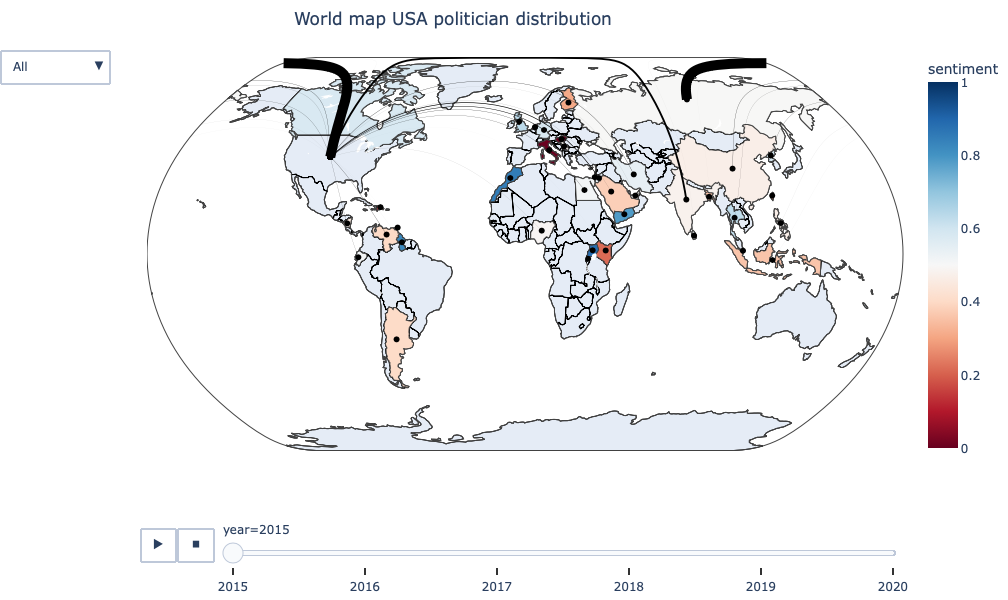

In [915]:
#import plotly.offline as off
#FOR NOW MAY FINAL
#may add one?
#years= ['2015','2016','2017','2018','2019','2020']


lat2 = [locO[1][0], -34.9964963]
lon2 = [locO[1][1], -64.9672817]

#figures


fig = px.choropleth(Coun_year,locations="country",locationmode='country names',animation_frame="year",
                    color="sentiment", # lifeExp is a column of gapminder
                    hover_name="country",
                    #hover_data="freq",# column to add to hover information
                    #color_discrete_sequence=Coun_year['color']
                    color_continuous_scale=px.colors.sequential.RdBu, projection="natural earth",
                    #mapbox_style="open-street-map")
                    )#,px.line_geo(lat=lat2,lon=lon2,animation_frame=['2015','2015'])]


#add by year
by_year=Coun_year.groupby('year')
#first 2015
#by_first=Coun_year[Coun_year['year']=='2015']
#fr=[fig.frames[0].data[0]]
#fr_name=[fig.frames[0].name]


for i,year in enumerate(by_year.indices) : 
    fr=[fig.frames[i].data[0]]#select the current frames and add next data on them
    y=by_year.get_group(year)
    for j,country in y.iterrows():
        fr.append(dict(type='scattergeo',
                         lat=[locO[1][0],country.lat], 
                         lon=[locO[1][1],country.lon],
                         geo='geo',
                         mode='lines+markers',
                         name='',
                         hovertext=country.country+' freq ='+str(country.freq),
                         line=dict(width=country.freq*10, color='black'),
                         #text=country.country,
                         #textposition='middle center',
                         #opacity=country.freq,
                         showlegend=False#,
                         #hoverinfo='text'
        ))
        #fr_name.append("2015")
        #dat.append(dict(type='scattergeo',
        if year=='2015':
            fig.add_traces(go.Scattergeo(
                             lat=[locO[1][0],country.lat], 
                             lon=[locO[1][1],country.lon],
                             geo='geo',
                             mode='lines+markers',
                             #marker.symbol="triangle-up",
                             name='',
                             #text=country,
                             hovertext=country.country+' freq ='+str(country.freq),
                             line=dict(width=country.freq*10, color='black'),
                             showlegend=False#,
                             #hoverinfo='text'
            ))

    fig.frames[i].data=fr
#fig.frames[0].name=fr_name
#by_second=Coun_year[Coun_year['year']=='2016']

#nd=[fig.frames[1].data[0]]
#dat=[fig.data[0]]

#for i,country in by_second.iterrows():
#    nd.append(dict(type='scattergeo',
#                     #coloraxis='coloraxis',
#                     lat=[locO[1][0],country.lat], 
#                     lon=[locO[1][1],country.lon],
#                     geo='geo',
#                     mode='lines',
 #                    name='',
                     #text=country,
#                     line=dict(width=country.freq*10, color='black'),
#                     showlegend=False#,
                     #hoverinfo='text'
#    ))
    
#updatemenus[0]['buttons'].append(dict(args=[{'visible': vis_list[s]},
#                                               {'mapbox.layers': lay_list[s]}],
#                                          label=party_list[s],
#                                          method='update'))

#fig.layout.updatemenus[0].buttons[1].args[1]['visible']=True
#.append(dict(args=[{'visible': True}],#vis_list[s]},
#                                               #{'mapbox.layers': lay_list[s]}],
#                                          label='new',
#                                          method='update'))
fig.update_geos(
    visible=True, resolution=110,# scope="world",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Blue"
)
fig.update_layout(height=600, margin={"r":0,"t":50,"l":0,"b":0},mapbox_style="carto-positron",title="World map USA politician distribution",title_x=0.45,
                 showlegend=False,hovermode='closest')
#off.iplot({'data': dat,'layout': b}, validate=False)

party_list=['All','Democratic','Republican']
steps=[]



updt=[fig.layout.updatemenus[0]]
#updt.append(go.layout.updatemenu.Button(dict(args=[{'visible': True}],
                                               #{'mapbox.layers': lay_list[s]}],
#                                                    label='All'#,
                                                    #method='update'
#                                                         )))
updt.append(dict(buttons=list([dict(args=[{'visible': True}],
                                               #{'mapbox.layers': lay_list[s]}],
                                        label='All'#,
                                          #method='update'
                                         ),
                               dict(args=[{'visible': True}], label='Democratic'),
                               dict(args=[{'visible': True}], label='Republican')
                              ])))

fig.layout.updatemenus=updt
fig.show()
#print(fig.layout.updatemenus)
#print(fig.frames[0])
#(fig.frames)
#print(fig.data)
#print(fig.frames)

In [ ]:
fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 500, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Year:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}


